In [1]:
import json

import numpy as np

from environments import ARESEAOptimization

In [2]:
with open("problems_3.json", "r") as f:
    problems = json.load(f)

problem = problems[0]
problem

{'initial': [-13.055176734924316,
  -8.750419616699219,
  -8.837950706481934,
  -0.002660162979736924,
  -0.005421869922429323],
 'incoming': {'mu_x': 0.00034758623223751783,
  'mu_xp': -2.2784792236052454e-05,
  'mu_y': 0.0006461531156674027,
  'mu_yp': -4.061725485371426e-05,
  'sigma_x': 0.00039956343243829906,
  'sigma_xp': 4.662976789404638e-05,
  'sigma_y': 0.00013723562005907297,
  'sigma_yp': 4.077742778463289e-05,
  'sigma_s': 4.245071067998651e-06,
  'sigma_p': 0.0006848658085800707,
  'energy': 88360138.74539271},
 'misalignments': [0.00030332794444860937,
  -9.165473295911738e-05,
  0.0002989406864419548,
  0.00021716449688990183,
  0.00023741136133197468,
  0.00027442377268954195,
  0.00037427117235767975,
  -4.5894708293436914e-05],
 'desired': [0.0, 0.0, 0.0, 0.0]}

In [3]:
env = ARESEAOptimization(backendargs={"measure_beam": "us"})
env

In [4]:
env.next_desired = problem["desired"]
# env.next_initial = problem["initial"]
env.next_initial = np.array([10.0, -10.0, 10.0, 0.0, 0.0])
env.backend.next_misalignments = problem["misalignments"]
env.backend.next_incoming = problem["incoming"]

observation = env.reset()
print(observation)
print(observation[-4:])

Param compute method -> pixel_size = array([1.32792e-05, 9.78760e-06])
In env self.achieved = array([-0.00017263,  0.00156602,  0.00020299,  0.00024937])
[ 1.00000000e+01 -1.00000000e+01  1.00000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.72629600e-04  1.56601600e-03  2.02994140e-04
  2.49365605e-04]
[-0.00017263  0.00156602  0.00020299  0.00024937]


In [5]:
env.backend._segment.AREABSCR1.read_beam

ParameterBeam(mu_x=-0.000176, mu_xp=-0.000101, mu_y=0.001560, mu_yp=0.000716, sigma_x=0.000228, sigma_xp=0.000269, sigma_y=0.000269, sigma_yp=0.000129, sigma_s=0.000004, sigma_p=0.000685, energy=88360138.745)

In [6]:
env.backend.binning

4

In [7]:
env.backend._segment.AREABSCR1.read_beam

ParameterBeam(mu_x=-0.000176, mu_xp=-0.000101, mu_y=0.001560, mu_yp=0.000716, sigma_x=0.000228, sigma_xp=0.000269, sigma_y=0.000269, sigma_yp=0.000129, sigma_s=0.000004, sigma_p=0.000685, energy=88360138.745)

In [8]:
env.backend._incoming

ParameterBeam(mu_x=0.000348, mu_xp=-0.000023, mu_y=0.000646, mu_yp=-0.000041, sigma_x=0.000400, sigma_xp=0.000047, sigma_y=0.000137, sigma_yp=0.000041, sigma_s=0.000004, sigma_p=0.000685, energy=88360138.745)

In [9]:
env.backend.misalignments

[0.00030332794444860937,
 -9.165473295911738e-05,
 0.0002989406864419548,
 0.00021716449688990183,
 0.00023741136133197468,
 0.00027442377268954195,
 0.00037427117235767975,
 -4.5894708293436914e-05]

In [10]:
env.backend.actuators

array([ 10., -10.,  10.,   0.,   0.])

In [12]:
env.backend._segment.AREABSCR1.extent

(-0.0040634352, 0.0040634352, -0.002495838, 0.002495838)

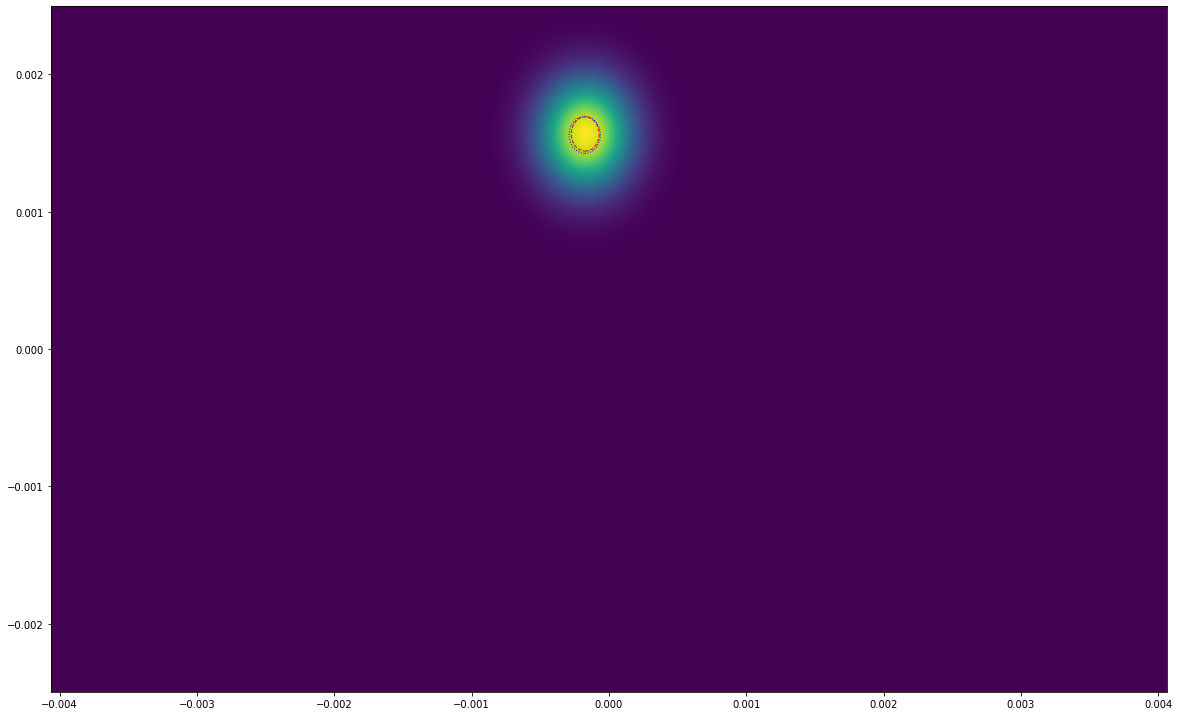

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.figure(figsize=(20,16))
plt.imshow(env.backend._segment.AREABSCR1.reading, extent=env.backend._segment.AREABSCR1.extent)
e = Ellipse((observation[-4],observation[-3]), observation[-2], observation[-1], ls="--", fill=False, color="red")
plt.gca().add_patch(e)
e2 = Ellipse((env.backend._segment.AREABSCR1.read_beam.mu_x,env.backend._segment.AREABSCR1.read_beam.mu_y), env.backend._segment.AREABSCR1.read_beam.sigma_x, env.backend._segment.AREABSCR1.read_beam.sigma_y, ls="dotted", fill=False, color="blue")
plt.gca().add_patch(e2)
plt.show()

In [1]:
from gym.wrappers import RescaleAction
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import Bounds, minimize
from tqdm import tqdm

from environments import ARESEAOptimization, ResetActuatorsToDFD

In [2]:
def pack_dataframe(fn):
    def wrapper(env, problem=None):
        observations, incoming, misalignments = fn(env, problem=problem)
        observations = np.array(observations)

        df = pd.DataFrame(np.arange(len(observations)), columns=["step"])
        df["q1"] = observations[:,0]
        df["q2"] = observations[:,1]
        df["q3"] = observations[:,2]
        df["cv"] = observations[:,3]
        df["ch"] = observations[:,4]
        df["mup_x"] = observations[:,5]
        df["mup_y"] = observations[:,6]
        df["sigmap_x"] = observations[:,7]
        df["sigmap_y"] = observations[:,8]
        df["mu_x"] = observations[:,9]
        df["mu_y"] = observations[:,10]
        df["sigma_x"] = observations[:,11]
        df["sigma_y"] = observations[:,12]
        for k in incoming.keys():
            df["incoming_"+k] = float(incoming[k])
        df["misalignment_q1_x"] = misalignments[0]
        df["misalignment_q1_y"] = misalignments[1]
        df["misalignment_q2_x"] = misalignments[2]
        df["misalignment_q2_y"] = misalignments[3]
        df["misalignment_q3_x"] = misalignments[4]
        df["misalignment_q3_y"] = misalignments[5]
        df["misalignment_screen_x"] = misalignments[6]
        df["misalignment_screen_y"] = misalignments[7]

        return df
    
    return wrapper

In [7]:
@pack_dataframe
def run(env, problem=None):
    if problem is not None:
        if "initial" in problem:
            env.unwrapped.next_initial = problem["initial"]
        if "incoming" in problem:
            env.unwrapped.backend.next_incoming = problem["incoming"]
        if "misalignments" in problem:
            env.unwrapped.backend.next_misalignments = problem["misalignments"]
        if "desired" in problem:
            env.unwrapped.next_desired = problem["desired"]

    observations = []

    observation = env.reset()

    observations.append(observation)
    incoming = env.backend._incoming.parameters
    misalignments = env.backend.misalignments

    def optfn(actuators):
        observation, objective, _, _ = env.step(actuators)
        observations.append(observation)
        return objective

    bounds = Bounds(env.action_space.low, env.action_space.high)
    # TODO: Should probably be options={"fatol": 4.5e-11}
    #       Because max pixel_size = 3.3198e-6
    #       Double that (two pixels) -> 6.6396e-06
    #       Squared error would then be 4.408428816e-11
    #       Round to 4.5e-11
    minimize(optfn, observation[:5], method="Nelder-Mead", bounds=bounds, options={"fatol": 4.5e-11, "xatol": 1})

    return observations, incoming, misalignments

In [8]:
def cache_to_file(fn):
    def wrapper(method, **kwargs):
        filename = f".cache_3/{method}.pkl"
        
        try:
            raise FileNotFoundError
            evaluation = pd.read_pickle(filename)
            print(f"Read {method} from cache file")
        except FileNotFoundError:
            evaluation = fn(method, **kwargs)
            # evaluation.to_pickle(filename)
        
        return evaluation

    return wrapper

In [9]:
@cache_to_file
def evaluate(method, description=None):
    env = ARESEAOptimization(backendargs={"measure_beam": "direct"})

    with open("problems_3.json", "r") as f:
        problems = json.load(f)
    problems = problems[:1]
    
    if "fdf" in method:
        env = ResetActuatorsToDFD(env)
    if "normalize" in method:
        env = RescaleAction(env, -1, 1)

    evaluation = []
    for i, problem in enumerate(tqdm(problems)):
        result = run(env, problem=problem)
        result["problem"] = i
        evaluation.append(result)
    evaluation = pd.concat(evaluation)
    evaluation["method"] = method
    evaluation["model"] = method
    if description is not None:
        evaluation["description"] = description
    
    return evaluation

In [10]:
df = evaluate("nelder-mead-fdf", description="Nelder-Mead Optimiser Starting at FDF")

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


In [15]:
# Compute MAE
df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

In [16]:
df.loc[0,"mae"]

0.0005582416961260606

In [13]:
import seaborn as sns

In [29]:
df.iloc[-1]["mae"]

2.9164196348574478e-05

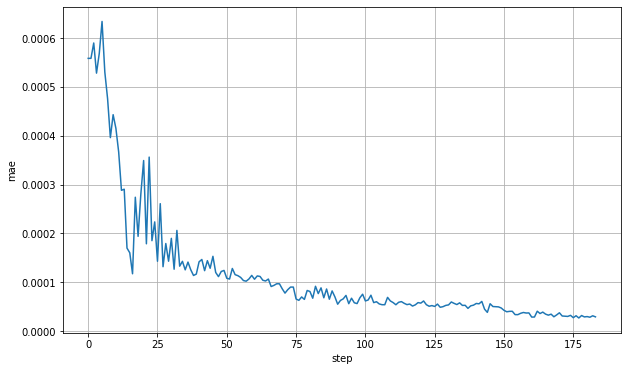

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="step", y="mae", data=df)
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()

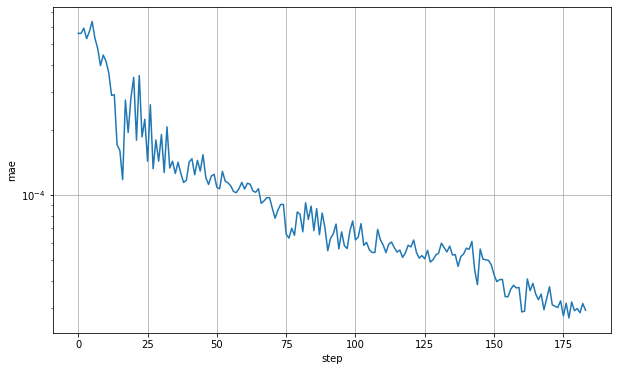

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="step", y="mae", data=df)
plt.yscale("log")
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()

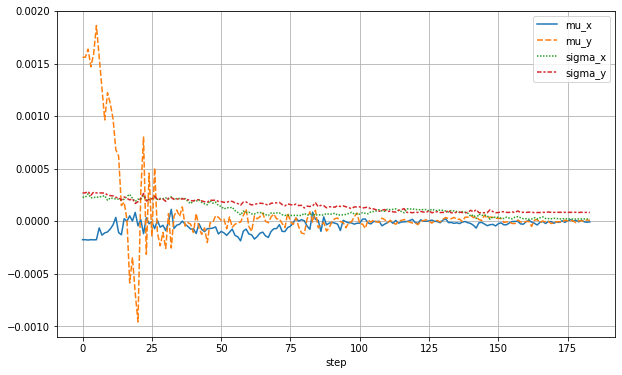

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df.set_index("step")[["mu_x","mu_y","sigma_x","sigma_y"]])
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()

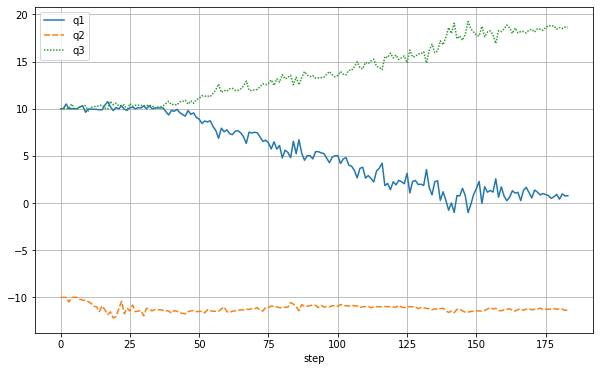

In [27]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df.set_index("step")[["q1","q2","q3"]])
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()

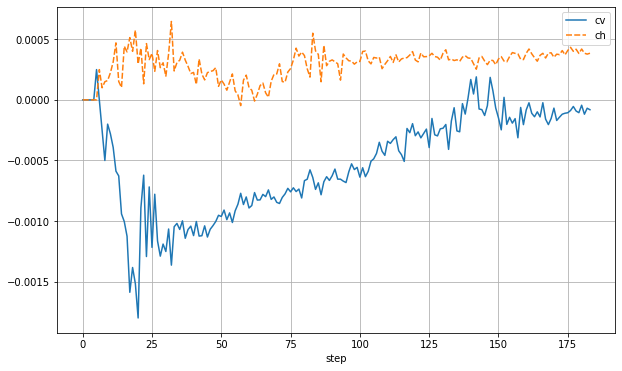

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df.set_index("step")[["cv","ch"]])
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()